#Exercice: introduction aux transformers 

Depuis 2017, les **transformers** ont gagné en popularité. Ces réseaux neurones très performants font intervenir un type de couche qui n'a pas été décrit en TP: la couche "attentionnelle". Cet exercice permet d'en découvrir le fonctionnement. Il s'achève sur l'apprentissage d'un petit transformer. 

Lancer les imports suivants et se placer dans le dossier *session2_prenomnom* 

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! ls .

BE_session2_exercice1.ipynb		  __pycache__
correction_BE_exercice_reid.ipynb	  utile_BE_session2.py
enonce_BE_exercice_reid_correction.ipynb


In [ ]:
os.chdir('drive/MyDrive/TP_ENM_2223/BE_dev/enonces_session2')

In [ ]:
from utile_BE_session2 import *

Pour entraîner notre premier transfgormer, nous reprenons le contexte d'une régression (TP1, exo 2). Les lignes de code suivantes permettent de visualiser les entrées et les cibles:

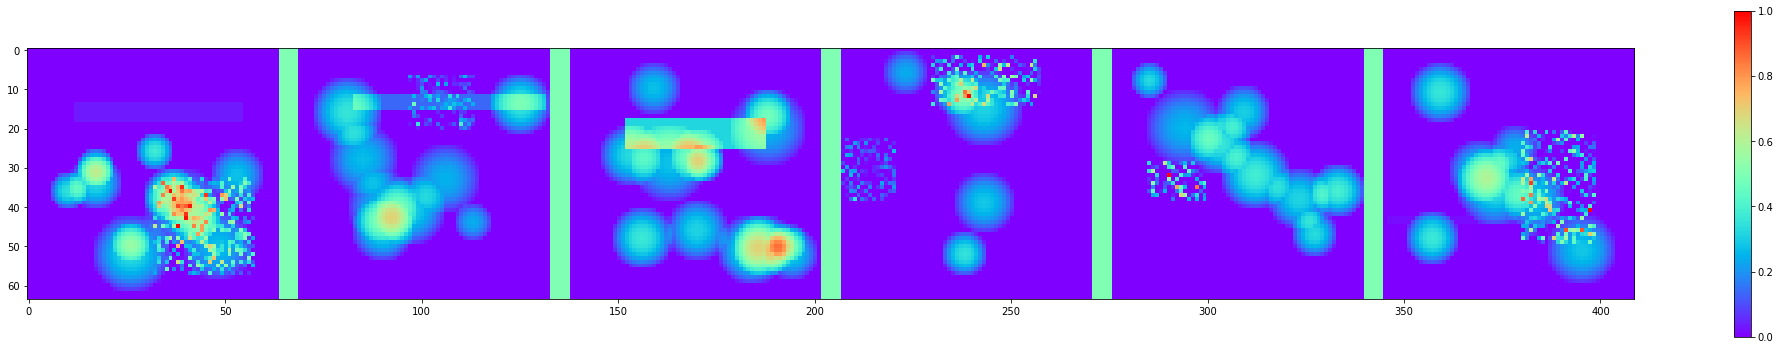

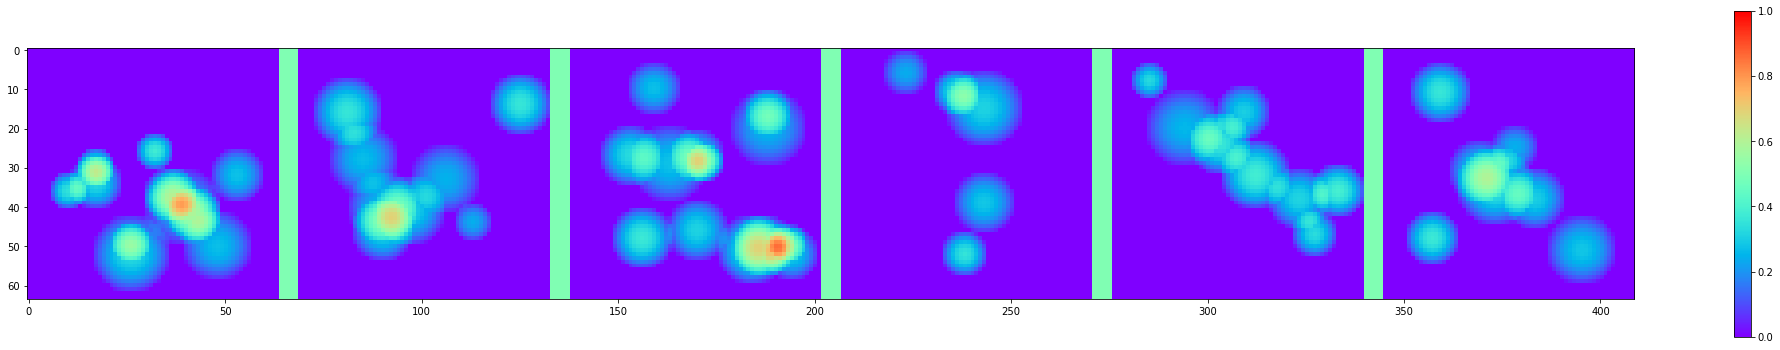

In [ ]:
input, target = gen(6) 

#versions bruitées (rectangles pleins et bruités)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

#versions propres (cellules seules)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Maintenant, chargeons les bibliothèques/fonctions utiles. Pour information, **timm** contient les briques de base qui permettent de coder/d'entraîner/de fine tuner la plupart des modèles récents, et en particulier les transformers (ViT, DEiT, BEiT, etc).

In [ ]:
! pip install timm
! pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from functools import partial
from timm.models.vision_transformer import Mlp, PatchEmbed , _cfg
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from pathlib import Path
import torch.nn.functional as F
from einops import rearrange


# Pour initialiser les poids:
def init_weights(m):
    if isinstance(m, nn.Linear):
        trunc_normal_(m.weight, std=0.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

Le "transformer" a été conçu pour une tâche de traduction de texte. Il opère donc sur une séquence de mots.\
Le "vision transformer" est une adaptation du transformer à des tâches de vision par ordinateur. Cette adaptation est fondée sur un découpage de l'image d'entrée en imagettes ("patch").
Chaque imagette est alors traitée comme un caractère musical dans le TP 6 partie 1: elle est projetée dans un espace de représentation propre au modèle.

Les hyperparamètres ci-dessous précisent, entre autres, les caractéristiques de l'image d'entrée, la taille des patch (8) du découpage, le nombre de dimensions de l'espace de représentation ("d_model").\
Le sens des autres hyperparamètres sera donné au fil de l'énoncé.


In [ ]:
image_size = [64,64]
channels = 1
n_cls = 1
patch_size = 8
d_model = 32
mlp_expansion_ratio = 4
d_ff = mlp_expansion_ratio * d_model
n_heads = 4
n_layers = 12

**Q1** Préciser la forme (.shape) du tenseur d'entrée (*input*).\
Que représente la première composante (chiffre 6) ? 

**Q2** La classe *PatchEmbedding* suivante permet de découper une image en patchs et projeter les patchs dans un epace de dimension donnée. 
L''instancier avec les hyperparamètres précédents.  
L'appliquer au tenseur *input* et stocker le résultat dans la variable *x*.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, d_model, channels):
        super().__init__()

        self.image_size = image_size
        if image_size[0] % patch_size != 0 or image_size[1] % patch_size != 0:
            raise ValueError("image dimensions must be divisible by the patch size")
        self.grid_size = image_size[0] // patch_size, image_size[1] // patch_size
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            channels, d_model, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, im):
        B, C, H, W = im.shape
        x = self.proj(im).flatten(2).transpose(1, 2)
        return x

Patch embedding:

In [ ]:
patch_embed = PatchEmbedding( ... )

x = ...

print(x.shape)

In [ ]:
patch_embed = PatchEmbedding(
            image_size,
            patch_size,
            d_model,
            channels,
        )

x = patch_embed(input)
print(x.shape)

**Q3** Quelle est la forme du tenseur $x$ ? Que représentent chacune des composantes ?

**Q4** : l'objet *embed* contient-il des paramètres entraînables ? Quel type de couche de neurones est employé ici ? Préciser le rôle du paramètre *stride* dans le "découpage" de l'imagette.

Dans cette opération de découpage, l'information sur la position relative des patchs dans l'image est perdue. Pour compenser cette perte, on associe à chacune des 64 positions possibles un vecteur de l'espace des représentations (tokénisation). On ajoute ces vecteurs aux projections.\
Ceci se traduit par les lignes suivantes:

In [ ]:
pos_embed = nn.Parameter(
                torch.randn(1, patch_embed.num_patches, d_model)
             )

x = x + pos_embed

**Q5** A ce stade, combien le réseau compte-t-il de paramètres entraînables ?

Le tenseur *x* est ensuite passé à travers une série de blocs identiques (*n_layers* représente le nombre de blocs).\
Chaque bloc est constitué, dans l'ordre :
- d'une opération de normalisation particulière (nous n'en discuterons pas ici)
- d'une couche "attentionnelle"
- d'une couche nommée "FeedForward". 

Voyons d'abord la couche attentionnelle.

Pour traiter le vecteur associé à un patch, il paraît nécessaire d'accéder au contenu d'autres patchs, plus ou moins proches. La couche attentionnelle encode un mécanisme de sélection des patchs les plus pertinents. 

Elle contient les opérations suivantes:
- un premier filtre linéaire renvoie, pour chaque vecteur de la séquence, trois vecteurs,  le premier est appelé "requête", le second "clef" et le troisième "valeur".
- pour chaque patch $i$, on évalue la "compatibilité" de la requête $q_i$ associée avec l'ensemble des clefs $k_j$. c'est modélisé par un produit scalaire suivi d'une opération de normalisation et d'une opération softmax.\
Les valeurs résultantes, $a_{ij}$, représentent le degré de pertinence de l'éléménent $j$ pour la compréhension de l'élément $i$. 
- on associe alors au patch $i$ la somme des valeurs  $v_j$ pondérées par les $a_{ij}$.

Ces opérations sont codées en matriciel dans la classe ci-dessous.
En pratique, une première opération (*qkv* dans le code) fournit $n_h$ triplets de matrices queries, keys, values (q,k,v) où les vecteurs requête, clef et valeur sont empilés. 
Les opérations décrites au-dessus sont donc répétées $n_h$ fois. $n_h$ (*n_heads* dans le code). Chacune d'entre elles est le fait d'une "tête attentionnelle".

In [ ]:
class Attention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = n_heads
        head_dim = d_model // n_heads
        self.scale = head_dim ** -0.5
        self.attn = None

        self.qkv = nn.Linear(d_model, d_model * 3)
        self.proj = nn.Linear(d_model, d_model)


    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.heads, C // self.heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )

        a = (q @ k.transpose(-2, -1)) * self.scale
        a = a.softmax(dim=-1)

        x = (a @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x, a

**Q6** Instancier Attention. Et l'appliquer à *x*. Commenter ligne à ligne le code de la classe. Que représente le symbole @ ?

In [ ]:
attn = Attention(... )
x, _ =  ...
print(x.shape)

In [ ]:
attn = Attention(d_model, n_heads)
x, _ =  attn(x)
print(x.shape)

torch.Size([6, 64, 32])


**Q7** Combien cette couche contient-elle de poids ?

**Q8** Dans un bloc, la couche attentionnelle est suivie d'un réseau de la classe FeedForward.
Quel nom a-t-on donné à ce type de réseau ?
Quelle est-ici la fonction d'activation ? La décrire en quelques termes.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, out_dim=None):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.act = nn.GELU()
        if out_dim is None:
            out_dim = d_model
        self.fc2 = nn.Linear(d_ff, out_dim)

    def unwrapped(self):
        return self

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

**Q9** Appliquer un objet de cette classe à *x*. A quoi correspond le paramètre *d_ff* ? Calculer en une ligne le nombre de paramètres entraînables dans cette couche.

Un bloc complet peut maintenant être défini. Il contient les deux couches précédentes et des opérations de normalisation.

In [ ]:
class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = Attention(d_model, n_heads)
        self.mlp = FeedForward(d_model, d_ff)


    def forward(self, x, mask=None, return_attention=False):
        y, attn = self.attn(self.norm1(x), mask)
        if return_attention:
            return attn
        x = x + self.mlp(self.norm2(y))
        return x

**Q10** Vérifier qu'une application successive de *n_layers* objets de type bloc ne change pas les dimensions du tenseur *x*.

In [ ]:
blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for i in range(n_layers)]
        )
norm = nn.LayerNorm(d_model)
nn.Linear(d_model, n_cls)
for blk in blocks:
    x = blk(x)

In [ ]:
print(x.shape)

torch.Size([6, 64, 32])


Nous en savons assez pour définir une classe simple de transformers:

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        n_layers,
        d_model,
        d_ff,
        n_heads,
        n_cls,
        channels=1,
    ):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            image_size,
            patch_size,
            d_model,
            channels,
        )
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.n_cls = n_cls


        self.pos_embed = nn.Parameter(
                torch.randn(1, self.patch_embed.num_patches, d_model) # pas +1
            )

        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads, d_ff) for i in range(n_layers)]
        )

        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_cls)

        trunc_normal_(self.pos_embed, std=0.02)

        self.pre_logits = nn.Identity()
        self.apply(init_weights)



    def forward(self, im):
        B, _, H, W = im.shape
        PS = self.patch_size
        x = self.patch_embed(im)
        pos_embed = self.pos_embed
 
        x = x + pos_embed

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x


**Q11** L'instancier avec les paramètres déjà présentés, la tester sur les images d'entrées. 

In [ ]:
encoder = VisionTransformer(...)

In [ ]:
encoder = VisionTransformer(image_size, patch_size,n_layers,d_model,d_ff,n_heads, n_cls, channels)
        
encoder(input).shape        
        


torch.Size([6, 64, 32])

Pour obtenir une une prédiction à l'échelle du pixel, nous allons nous donner une classe de décodeurs (*DecoderLinear*). La classe *Denoiser* qui suit combine  l'encodeur et le décodeur.

In [ ]:
class DecoderLinear(nn.Module):
    def __init__(self, n_cls, patch_size, d_model):
        super().__init__()

        self.d_model = d_model
        self.patch_size = patch_size
        self.n_cls = n_cls

        self.head = nn.Linear(self.d_model, self.n_cls)
        self.apply(init_weights)


    def forward(self, x):

        GS = 64 // self.patch_size
        x = self.head(x)
        x = rearrange(x, "b (h w) c -> b c h w", h=GS)

        return x

In [ ]:
class Denoiser(nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        n_cls,
    ):
        super().__init__()
        self.n_cls = n_cls
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder



    def forward(self, im):
        H_ori, W_ori = im.size(2), im.size(3)
        im = padding(im, self.patch_size)
        H, W = im.size(2), im.size(3)

        x = self.encoder(im)

        x = self.decoder(x)

        x = F.interpolate(x, size=(H, W), mode="bilinear")

        return x



**Q12** Instancier un Denoiser. Par quel mécanismes la sortie est-elle portée à la taille de l'image d'entrée ?

In [ ]:
model = Denoiser(encoder, decoder, n_cls)

model(input).shape

torch.Size([6, 1, 64, 64])

**Q13** Reprendre le code du TP2 partie 1 pour entraîner le model sur carte GPU (20 époques, optimizer d'ADAM avec des paramètres standard). Visualiser la sortie et commenter.

In [ ]:
#vérification de la mise à disponibilité de la carte gpu:
print(torch.cuda.get_device_name(0))

fcn = model.cuda()

Tesla T4


In [ ]:
def criterion(output,target):
  return torch.mean((output-target)**2)

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 40 
nbatches = 100
batchsize = 32

train_losses = []


for epoch in range(nepochs):
    

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs
        

        input,target = gen(batchsize) 

        input = input.cuda()
        target = target.cuda()

        
        optimizer.zero_grad()        
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()
        
        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()     

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)    
    print('epoch loss : \n')
    print(epoch_loss)


Epoch 0
epoch loss : 

0.0069357697
Epoch 1
epoch loss : 

0.004909068
Epoch 2
epoch loss : 

0.0042072698
Epoch 3
epoch loss : 

0.003905076
Epoch 4
epoch loss : 

0.0036877487
Epoch 5
epoch loss : 

0.0036294947
Epoch 6
epoch loss : 

0.003553079
Epoch 7
epoch loss : 

0.0034030257
Epoch 8
epoch loss : 

0.0033833387
Epoch 9
epoch loss : 

0.0033440727
Epoch 10


KeyboardInterrupt: ignored

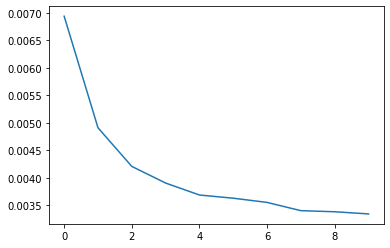

In [ ]:
plt.plot(train_losses)

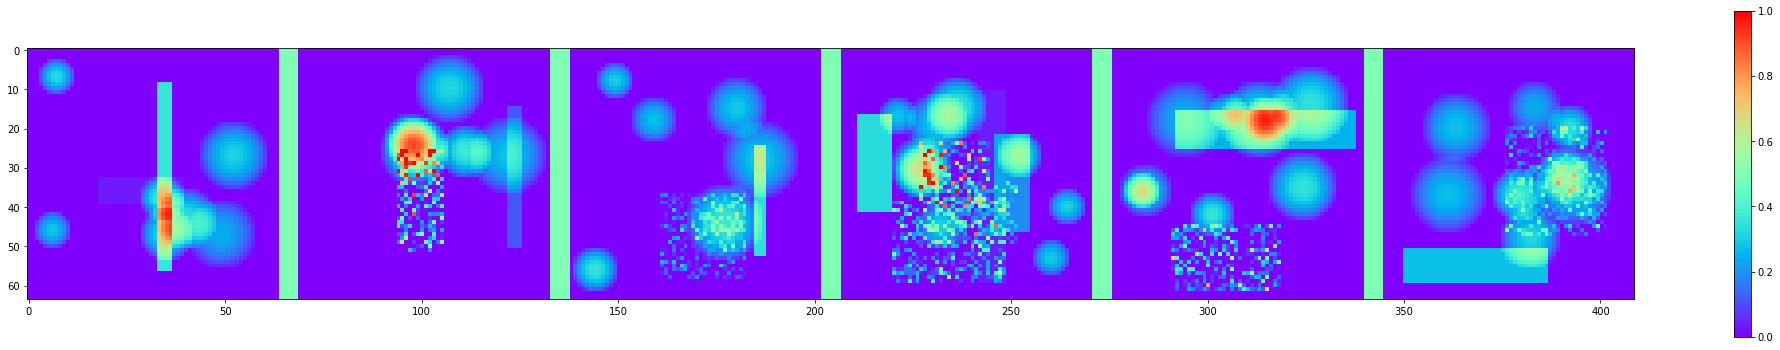

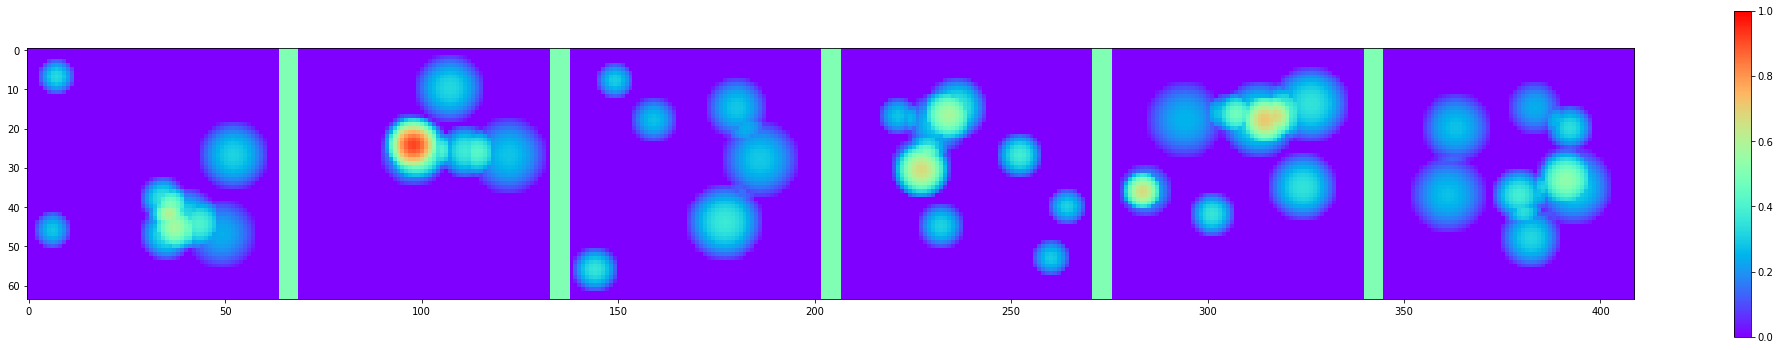

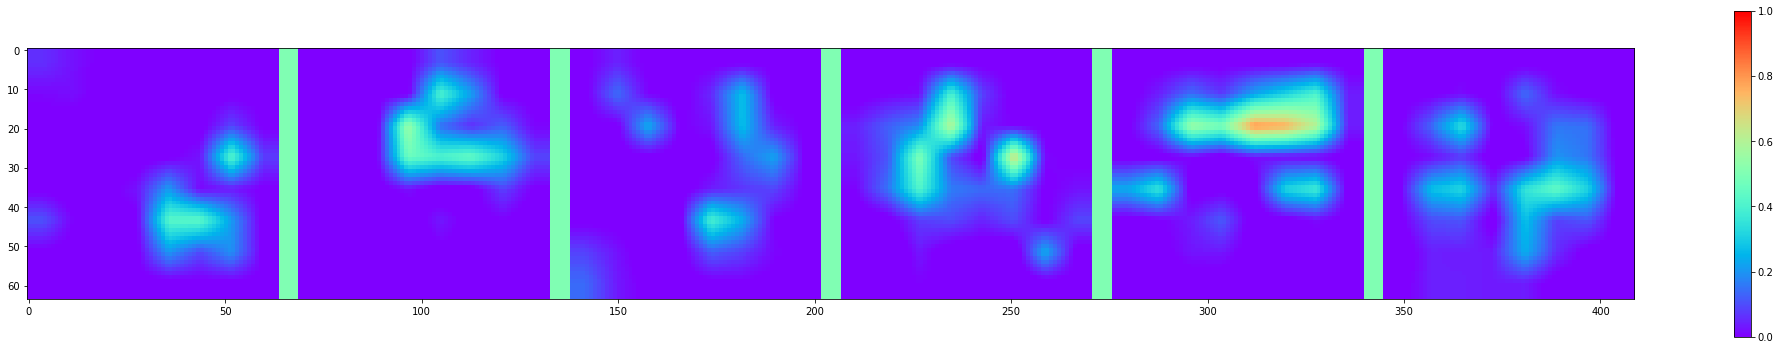

In [ ]:
#visualisation:

fcn.eval()

target = make_batch(6, rec = 0., noisy_rec= 0., disc = 0.002).cuda()
noise =  make_batch(6, rec = 0.0003, noisy_rec= 0.0003, disc = 0.).cuda()
input = target + noise

output = fcn(input)



fig = plt.figure(0, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale=0,max_scale=1)
fig2 = plt.figure(1, figsize=(36, 6))  #seconde ligne: vérité terrain
voir_batch2D(target.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)